In [2]:
#we import what we need to create the predictive model

import pandas as pd
import numpy as np
import seaborn as sb
import warnings
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
#we create the dataframe containing the dataset

data = pd.read_csv('student-por.csv', sep=';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [ ]:
# we print it to understand it better
data.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,4,2,1,2,5,6,12,12,13
6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0,13,12,13
7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,2,10,13,13
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,2,2,1,1,1,0,15,16,17
9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,5,1,1,1,5,0,12,12,13


In [ ]:
# we preprocess the data, we perform onehot encoding on every categorical variable using pd.get_dummies

data_onehot = data.copy()

data_onehot = pd.get_dummies(data_onehot, columns=['school'], prefix = ['school'])
data_onehot = pd.get_dummies(data_onehot, columns=['sex'], prefix = ['sex'])
data_onehot = pd.get_dummies(data_onehot, columns=['address'], prefix = ['address'])
data_onehot = pd.get_dummies(data_onehot, columns=['famsize'], prefix = ['famsize'])
data_onehot = pd.get_dummies(data_onehot, columns=['Pstatus'], prefix = ['Pstatus'])
data_onehot = pd.get_dummies(data_onehot, columns=['Mjob'], prefix = ['Mjob'])
data_onehot = pd.get_dummies(data_onehot, columns=['Fjob'], prefix = ['Fjob'])
data_onehot = pd.get_dummies(data_onehot, columns=['reason'], prefix = ['reason'])
data_onehot = pd.get_dummies(data_onehot, columns=['guardian'], prefix = ['guardian'])
data_onehot = pd.get_dummies(data_onehot, columns=['schoolsup'], prefix = ['schoolsup'])
data_onehot = pd.get_dummies(data_onehot, columns=['famsup'], prefix = ['famsup'])
data_onehot = pd.get_dummies(data_onehot, columns=['paid'], prefix = ['paid'])
data_onehot = pd.get_dummies(data_onehot, columns=['activities'], prefix = ['activities'])
data_onehot = pd.get_dummies(data_onehot, columns=['nursery'], prefix = ['nursery'])
data_onehot = pd.get_dummies(data_onehot, columns=['higher'], prefix = ['higher'])
data_onehot = pd.get_dummies(data_onehot, columns=['internet'], prefix = ['internet'])
data_onehot = pd.get_dummies(data_onehot, columns=['romantic'], prefix = ['romantic'])
data_onehot.head(10)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,1,3,4,0,11,11,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,2,9,11,11,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,3,3,6,12,13,12,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,1,5,0,14,14,14,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,2,5,0,11,13,13,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0
5,16,4,3,1,2,0,5,4,2,1,2,5,6,12,12,13,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0
6,16,2,2,1,2,0,4,4,4,1,1,3,0,13,12,13,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0
7,17,4,4,2,2,0,4,1,4,1,1,1,2,10,13,13,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0
8,15,3,2,1,2,0,4,2,2,1,1,1,0,15,16,17,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0
9,15,3,4,1,2,0,5,5,1,1,1,5,0,12,12,13,1,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0


In [ ]:
#we produce the inputs and outputs from the dataset
#we consider the final grade (G3) as the output and every other variable as input except for G1 and G2

X = data_onehot.drop(['G3', 'G2', 'G1'], axis =1) #X is the input dataframe
Y = data_onehot[['G3']] #Y is the output dataframe

In [ ]:
# we split the dataset
# we do not create the validation set because we will validate directly in the neural nets with validation split
# and checkpoints method

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [ ]:
# standardization of dependent variables

scale_X = StandardScaler()
scale_Y = StandardScaler()

X_train_normalized = scale_X.fit_transform(X_train)
Y_train_normalized = scale_Y.fit_transform(Y_train)
X_test_normalized = scale_X.fit_transform(X_test)

We will now try using a different approach: we will use a regression model based on XGBoost

In [ ]:
import sklearn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softmax',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

random_search.fit(X, Y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7ff81cd4e8d0>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=1,
                                           objective='multi:softmax...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
                                           verbosity=1),
                   iid='deprec

In [ ]:
#we round each value of the list because the final mark is an integer from 0 to 20

Y_pred = random_search.predict(X_test)

pred = [round(el) for el in Y_pred] #python comprehension

In [ ]:
#We compute the MSE
print('the mean squared error with respect to the test set is', mean_squared_error(Y_test, pred))

the mean squared error with respect to the test set is 12.276923076923078


In [ ]:
#we create a dataframe to visualize the predictions
#The dataframe has two columns, one of them with the ground-truth grades and the other with the predicted grades

final_results = pd.DataFrame(data = {'true_grades': Y_test['G3'].to_list(), 'predicted_grades': pred})

In [ ]:
#we print the results for visualization

final_results.head(30)

,true_grades,predicted_grades
0,0,11
1,11,11
2,8,10
3,8,13
4,11,11
5,11,11
6,15,13
7,13,13
8,16,11
9,14,11


In [ ]:
print(confusion_matrix(Y_test, pred))
print(accuracy_score(Y_test, pred))

[[ 0  0  0  0  0  2  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5 15  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  2  2  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  4  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  7  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  6  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  3  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]]
0.23846153846153847


Now we try to predict the final grade G3 without any knowledge regarding the grades in the two semesters G1 and G2

Text(0, 0.5, 'predicted grades')

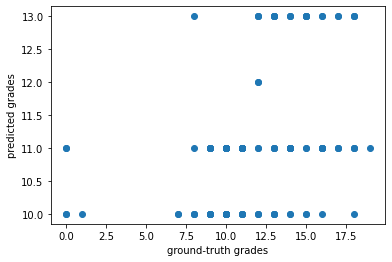

In [ ]:
#we expect the points to lie the y=x line
# for xgboost this looks really bad

plt.scatter(Y_test['G3'].to_list(), pred)
plt.xlabel('ground-truth grades')
plt.ylabel('predicted grades')

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, multi_class="multinomial", class_weight="balanced", penalty="l2").fit(X_train, Y_train)

pred = clf.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(confusion_matrix(Y_test, pred))
print(accuracy_score(Y_test, pred))

[[1 0 0 0 1 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 1 0 0 0 0 0 0 1 1 0]
 [1 0 1 1 3 1 1 0 0 0 1 1 0 2 0]
 [0 0 1 3 4 0 1 1 0 3 2 3 1 1 0]
 [0 0 1 1 2 2 3 3 1 0 2 2 3 0 0]
 [0 0 0 0 0 0 1 1 2 1 3 0 2 0 0]
 [0 0 0 0 1 1 0 2 2 1 2 1 1 2 0]
 [1 0 0 1 0 0 0 0 2 1 4 1 2 0 0]
 [0 0 0 0 0 0 1 1 3 0 0 0 3 1 0]
 [0 0 0 0 0 0 0 0 2 0 4 1 2 0 0]
 [0 0 0 1 0 0 0 1 0 0 1 0 2 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 4 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]
0.1076923076923077


In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, Y_train)
pred = regr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [ ]:
pred = [round(el) for el in pred] #python comprehension
print(confusion_matrix(Y_test, pred))
print(accuracy_score(Y_test, pred))

[[ 0  0  0  1  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  2  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  4  1  2  1  4  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  1  3 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3 17  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]]
0.12307692307692308


In [8]:
# baseline
data.G3.value_counts().divide(len(data))

11    0.160247
10    0.149461
13    0.126348
12    0.110940
14    0.097072
15    0.075501
16    0.055470
9     0.053929
8     0.053929
17    0.044684
0     0.023112
18    0.023112
7     0.015408
6     0.004622
19    0.003082
5     0.001541
1     0.001541
Name: G3, dtype: float64